# Use the class


In [37]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *



class Autoencoder():
    def __init__(self,tipe,n_qubit_autoencoder,n_qubit_trash,device):
        '''
            type                string  Define the type of autoencoder, possible values are  fd, ld
            n_qubit_autoencoder int     Dimension of the input space
            n_qubit_trash       int     Dimension of the trash space
        '''
        if tipe not in ['fd']:
            raise Exception('Type not supported')
        self.__tipe = tipe
        self.__n_qubit_auto = n_qubit_autoencoder
        self.__n_qubit_trash = n_qubit_trash
        self.__n_qubit_swap=n_qubit_trash +1
        self.__n_qubit = n_qubit_autoencoder+self.__n_qubit_swap
        self.__dvc=device
        self.__num_params=sum([ 2*(n_qubit_autoencoder-i)+2 for i in range(n_qubit_trash)])
        self.__num_params=3*n_qubit_autoencoder+n_qubit_autoencoder*(n_qubit_autoencoder-1)
        self.__wq=[np.array([random.uniform(0, np.pi) for _ in range(self.__num_params)], requires_grad=True)]

    # def autoencoder_fulldense_train(self,param):
    #     strprm=0
    #     for a in range(self.__n_qubit_trash):
    #         start=self.__n_qubit_trash+a+1
    #         current_param=2*(self.__n_qubit_auto-a)+2
    #         self.fclayer(self.__n_qubit_auto-a,param[strprm:current_param+strprm],start=start)
    #         strprm=current_param+strprm
    
    def autoencoder_fulldense_train(self,param):
        strprm=0
        self.original_auto(self.__n_qubit_auto,param,start=self.__n_qubit_swap)

    def create_isotropic_state(self, p, start):
        qml.Hadamard(wires=start)
        theta = p
        for i in range(self.__n_qubit_auto-1):
            qml.CNOT(wires=[start+i , start+1+i])
        for i in range(self.__n_qubit_auto):
            qml.RX(theta, wires=start+i)
        for i in range(self.__n_qubit_auto-1):
            qml.CNOT(wires=[start+i , start+1+i])

    # def fclayer(self,qb,parameter,start):
    #     for i in range(start,qb+start):
    #         qml.RY(parameter[(i-start)*2+1],wires=i)
    #     for i in range(start,qb+start-1,2):
    #         qml.CNOT(wires=[i,i+1])
    #     for i in range(start+1,qb+start-1,2):
    #         qml.CNOT(wires=[i,i+1])
    #     for i in range(start,qb+start):
    #         qml.RX(parameter[(i-start)*2],wires=i)

    def fclayer(self,qb,parameter,start):
        for i in range(start,qb+start):
            qml.RY(parameter[i-start],wires=i)
        for i in range(start,qb+start):
            qml.RX(parameter[i-start +qb],wires=i)
        for i in range(start+1,qb+start):
            qml.CNOT(wires=[start,i])
        qml.RY(parameter[-2],wires=start)
        qml.RX(parameter[-1],wires=start)

    def original_auto(self,qb,parameter,start):
        for i in range(start,qb+start):
            qml.RY(parameter[i-start],wires=i)
        for i in range(start,qb+start):
            qml.RX(parameter[i-start +qb],wires=i)
        pindex=0
        for j in range(start,qb+start):
            for i in range(start,qb+start):
                if j != i:
                    qml.CRX(parameter[pindex +2*qb],wires=[j,i])
                    pindex-=-1
        for i in range(start,qb+start):
            qml.RY(parameter[i-start+2*qb+qb*(qb-1)],wires=i)


    def dense(self,a,b,parameters):
        qml.RY(parameters[0],wires=a)
        qml.RY(parameters[1],wires=b)
        qml.RX(parameters[2],wires=a)
        qml.RX(parameters[3],wires=b)
        qml.CNOT(wires=[a,b])
        qml.RY(parameters[4],wires=a)
        qml.RY(parameters[5],wires=b)
        qml.CNOT(wires=[b,a])

    def pool(self,a,b):
        qml.CRZ(np.pi,wires=[a,b])
        qml.X(a)  
        qml.CRX(np.pi,wires=[a,b])

    def autoencoder(self,offset,param,repetition,n_qubit):
        start=0
        layerparam=6
        for i in range(repetition):
            if start % 2!=0:
                raise Exception('The number of qubits should be a power of 2 greater than 2 to the power of repetition')

            for a in range(start,( n_qubit-start)//2+start):
                param_corrente=sum([layerparam*n_qubit//2**(j+1) for j in range(i)])+(a-start)*layerparam            
                a+=offset
                self.dense(a,a+(n_qubit-start)//2,param[param_corrente:param_corrente +layerparam])
                self.pool(a,a+(n_qubit-start)//2)
            start+=n_qubit//(2**(i+1))


    def original_swap(self):
        qml.Hadamard(wires=0)
        for wires in range(1,self.__n_qubit_swap):
            qml.CSWAP(wires=[0,wires,wires+self.__n_qubit_swap-1])
        qml.Hadamard(wires=0)


    def plot_cirq(self):
        @qml.qnode(self.__dvc,diff_method='adjoint')
        def trainer(param,p):
            
            self.create_isotropic_state(p,self.__n_qubit_swap)
            qml.Barrier()
            self.autoencoder_fulldense_train(param)
            qml.Barrier()
            # self.original_swap()
            return qml.probs(list(range(self.__n_qubit_swap,self.__n_qubit_swap+self.__n_qubit_trash)))
        
        fig, ax = qml.draw_mpl(trainer)(self.__wq[-1],.5)
        plt.show()


    def train(self, X , opt,epochs,batch_size=None,restart=None):
        loss = []   
        if batch_size is None:
            batch_size=len(X)
        @qml.qnode(self.__dvc,diff_method='adjoint')
        def trainer(param,p):
            self.create_isotropic_state(p,self.__n_qubit_swap)
            qml.Barrier()
            self.autoencoder_fulldense_train(param)
            qml.Barrier()
            # self.original_swap()
            return qml.probs(list(range(self.__n_qubit_swap,self.__n_qubit_swap+self.__n_qubit_trash)))
        for r in restart():
            for epoch in range(epochs):
                batch_loss=[]
                for i, X_batch in enumerate([X[i:i + batch_size] for i in range(0, len(X), batch_size)]):
                    def loss_function(w): 
                        pred =np.array([1-trainer(w,x)[0] for x in X_batch], requires_grad=True)
                        current_loss = pred.mean()
                        return current_loss

                    weights, loss_value = opt.step_and_cost(loss_function, self.__wq[-1])
                    batch_loss.append(loss_value)
                    print(f'Epoch {epoch}, Batch:{i} Loss = {np.mean(batch_loss)}',end='\r')
                loss.append(np.mean(batch_loss))
                self.__wq.append(weights)
            opt.reset()   
        self.__loss=loss
        return loss, self.__wq.copy()

    # Note that this is the worst tabu in Deep learning, 
    # you should never take the best parameter based on 
    # training results. 
    # Having said that Ill change this as soon as I 
    # implement the evaluation of the validation set.
    def best_params(self):
        return self.__wq[np.argmin(self.__loss)+1] 
    
    def autoencoder_fulldense(self,param,wire):
        strprm=0
        self.original_auto(self.__n_qubit_auto,param,start=wire)

    def get_cirq(self,wire):
        self.autoencoder_fulldense(self.best_params(),wire)
    
    def plot_loss(self):
        plt.plot(list(range(len(self.__loss))),self.__loss)

    def plot_weights(self):
        i=0
        for a in np.array(self.__wq).T:
            plt.plot(range(len(a)),a,label=[i])
            i-=-1
        plt.legend()

In [38]:
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer,AdagradOptimizer
n_trash_qubit=2
n_qubit_autoencoder=4
n_qubit=n_qubit_autoencoder+n_trash_qubit+1 
dvc = qml.device('default.qubit', wires=n_qubit, shots=None)
import warnings
warnings.filterwarnings("ignore")

ae = Autoencoder('fd',n_qubit_autoencoder,n_trash_qubit,dvc)
for a in range(2):
    epochs= 75
    n=100
    opt=AdamOptimizer(stepsize=.2)
    X=np.random.rand(n)*2*np.pi
    np.random.shuffle(X)

    history = ae.train(X,opt,epochs,)


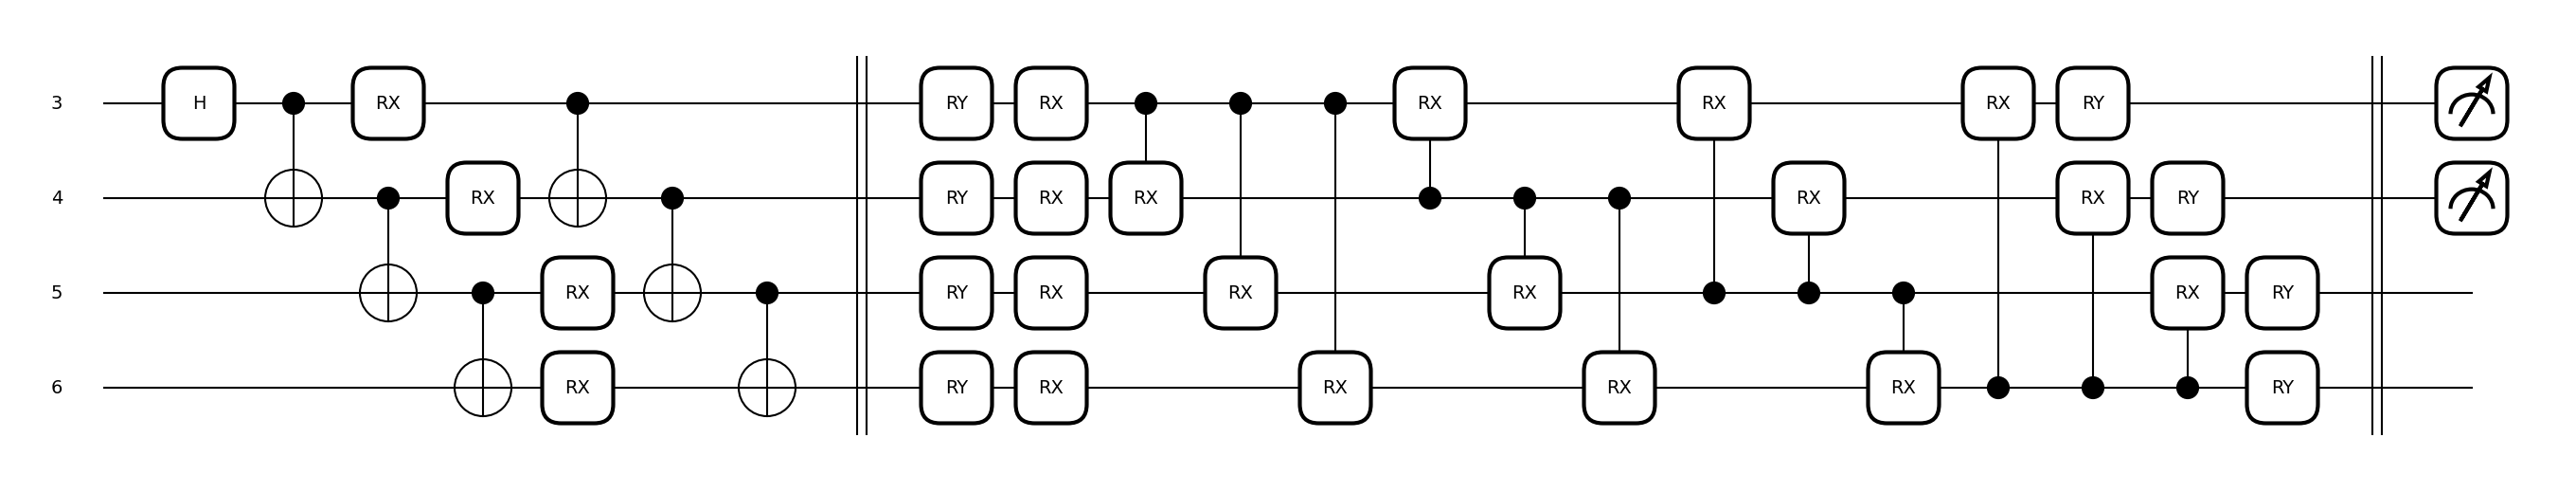

In [39]:
ae.plot_cirq()

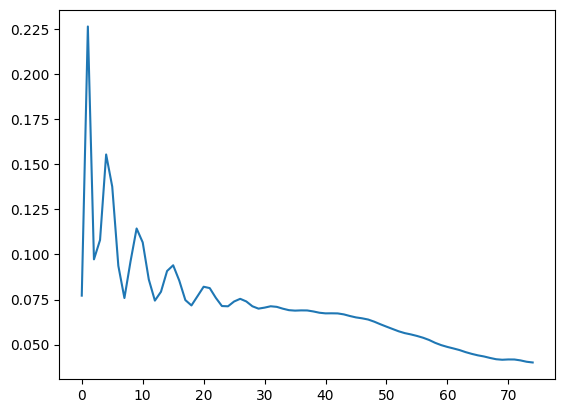

In [40]:
ae.plot_loss()

## Swap test for the dimentionality reduced state

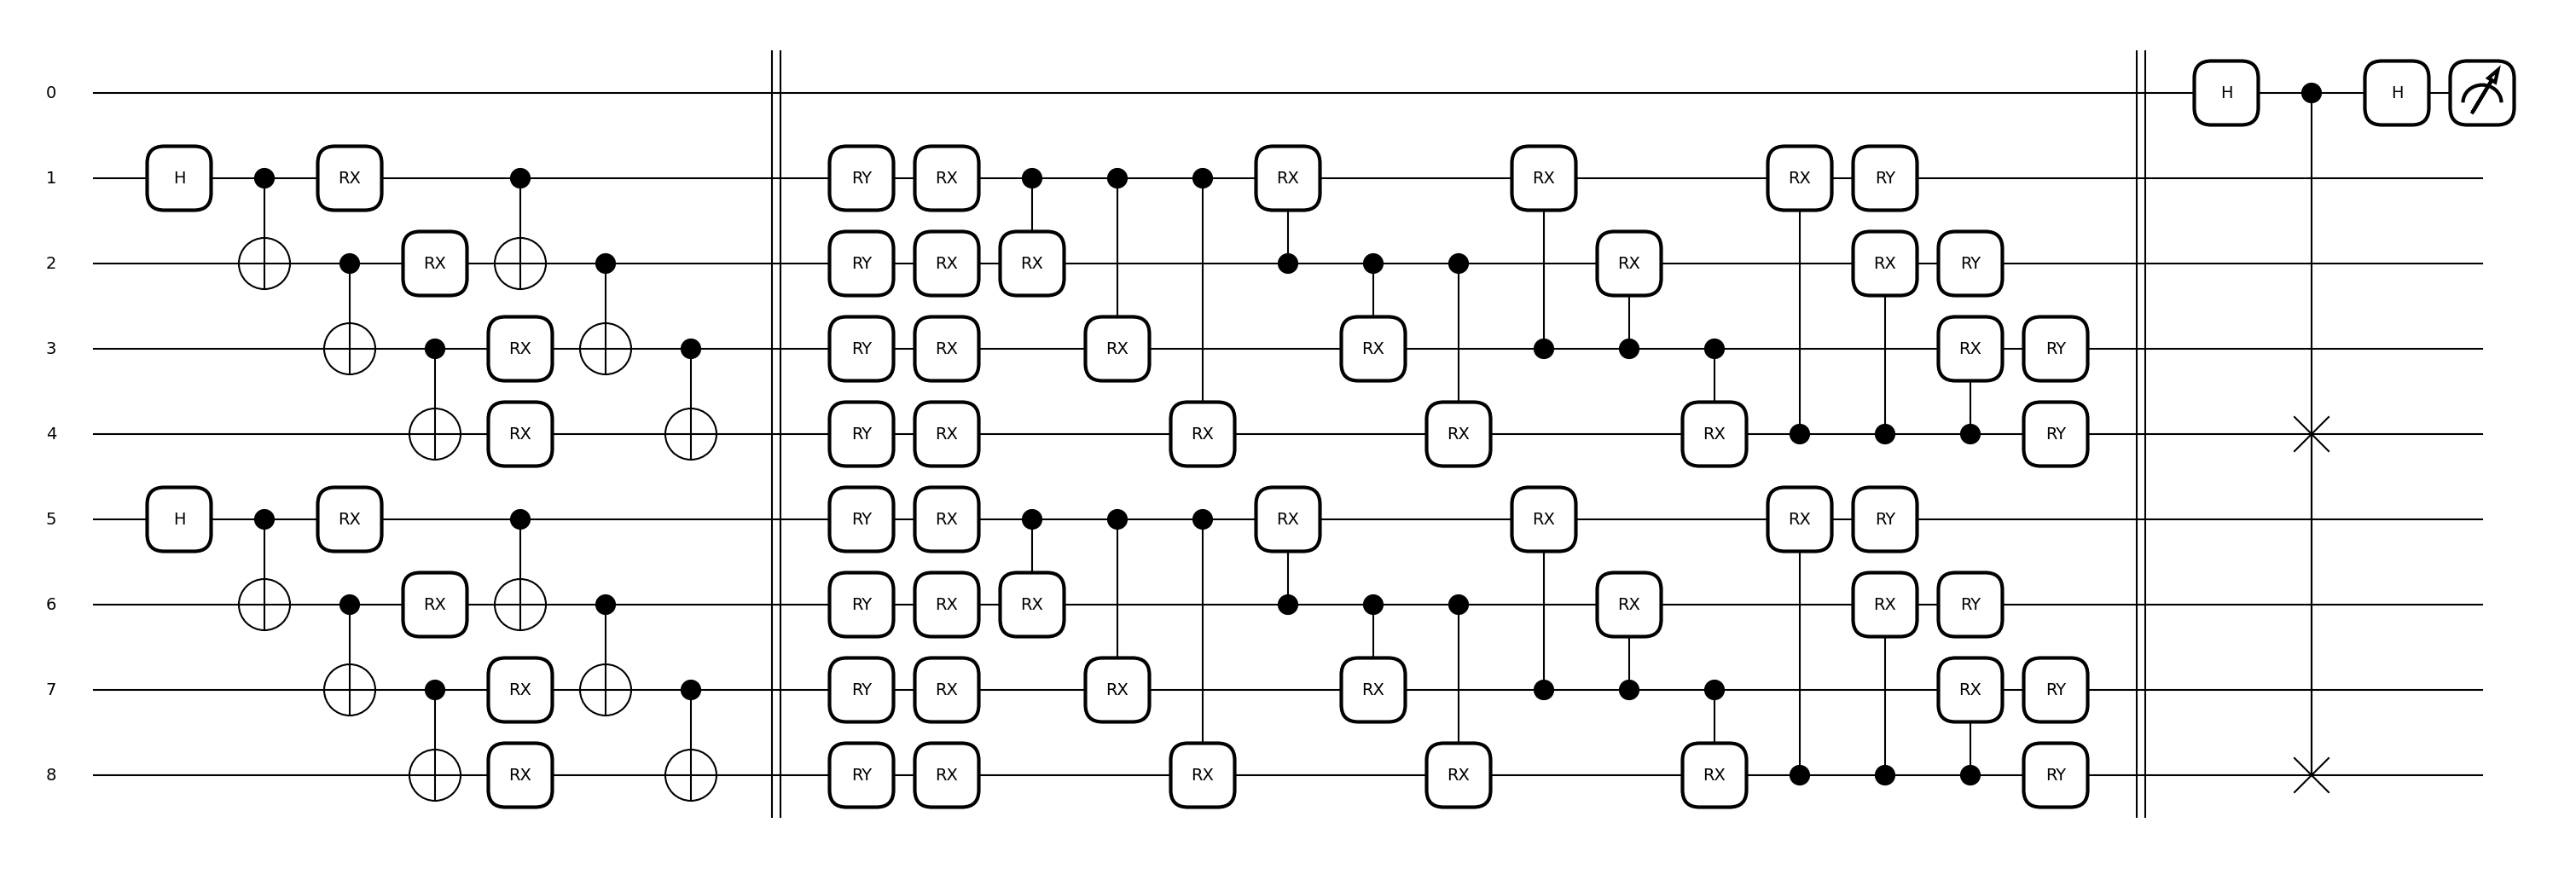

In [41]:
fig, ax = qml.draw_mpl(compare_state_ae(4,3),ae)([3,6])
plt.show()


## Swap test for the initial state

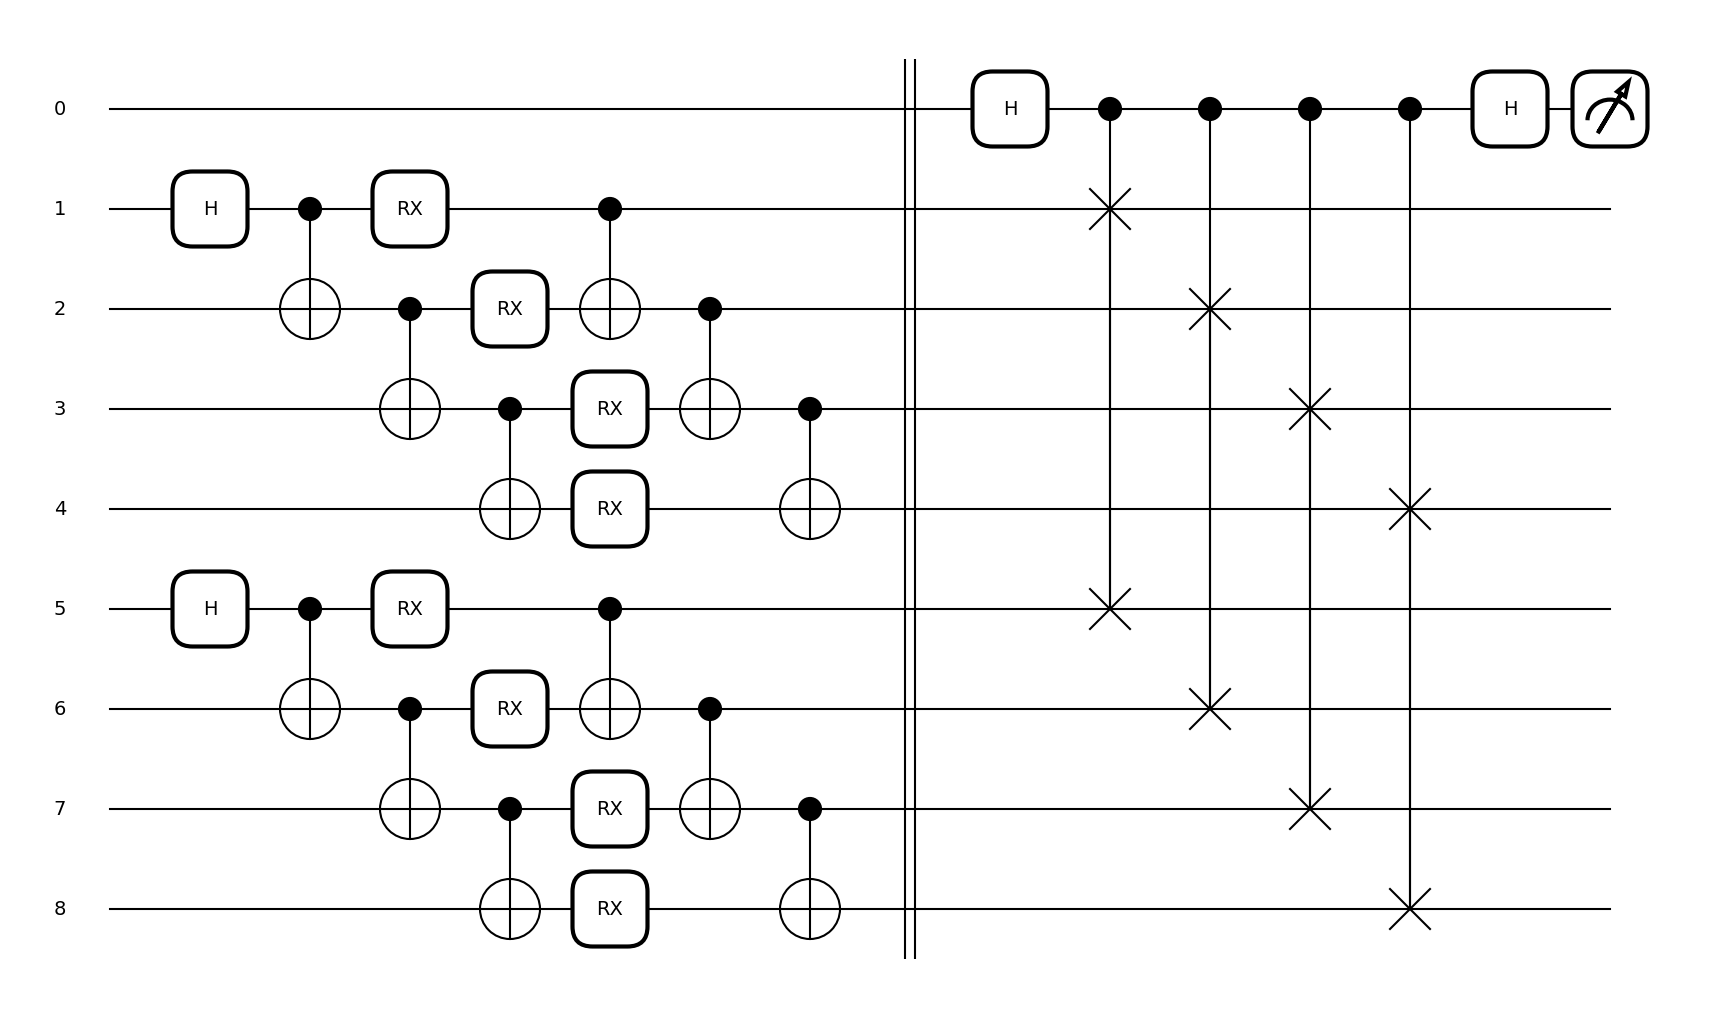

In [42]:
fig, ax = qml.draw_mpl(compare_state_orig(4))([3,6])
plt.show()


MSE of the error is 0.004135202039999999


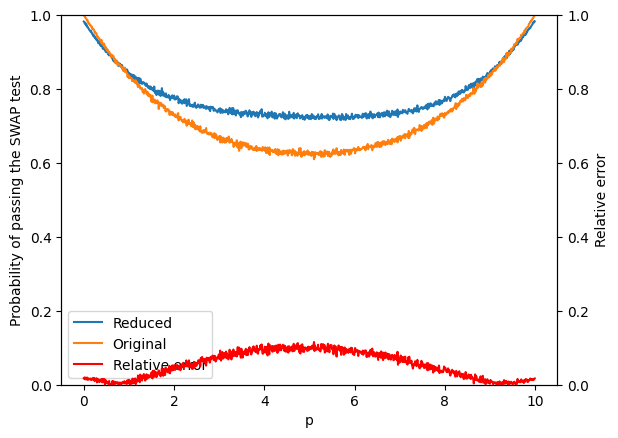

In [45]:
compare_fidelity(n_qubit_autoencoder,n_trash_qubit)